# Мониторинг экосистемы: классификация звуков птиц

Проект для автоматического мониторинга экосистемы через анализ звуков птиц.

**Что делает:**
- Собирает аудиозаписи птиц с открытого API Xeno-Canto
- Классифицирует звуки с помощью предобученной модели машинного обучения
- Оценивает качество распознавания
- Генерирует оповещения о важных событиях (редкие виды, аномалии)

**Технологии:** Python, Transformers (Hugging Face), librosa, pandas, scikit-learn

#1. Установка библиотек

In [1]:
!pip install transformers datasets librosa soundfile pandas matplotlib


#2. Импорт модели

In [1]:
from transformers import pipeline

# Загружаем предобученную модель для классификации звуков птиц
# Модель взял с Hugging Face, она уже обучена на разных видах птиц
classifier = pipeline("audio-classification", model="dima806/bird_sounds_classification")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Device set to use cuda:0


#3. Скачивание аудио с Xeno-Canto (API v3)

## Сбор данных

Для тестирования модели используем аудиозаписи с сайта Xeno-Canto — это открытая база звуков птиц со всего мира.

**Как это работает:**
1. Берем список видов птиц из конфига модели
2. Для каждого вида делаем запрос к API Xeno-Canto
3. Скачиваем по 5 записей на каждый вид
4. Используем асинхронное скачивание чтобы не ждать час

Записи сохраняются в папку `bird_sounds/` в формате mp3.

In [7]:
# Используем асинхронное скачивание - так быстрее чем качать файлы по одному
import aiohttp
import asyncio
import os
import requests

# Ключ API для Xeno-Canto
API_KEY = "67ef0bb780f20c7dae03d3d0a6794102b39b9acf"

# Получаем список всех классов птиц из модели
id2label = classifier.model.config.id2label
classes = list(id2label.values())

# Папка для сохранения аудио
os.makedirs("bird_sounds", exist_ok=True)

# Шаг 1: Собираем все ссылки на файлы
# Сначала делаем обычные запросы к API чтобы получить URLs
tasks_list = []
print("Collecting file URLs...")

for cname in classes:
    # Формируем запрос - ищем по английскому названию птицы
    query = f'en:"{cname}" grp:birds'
    url = f"https://xeno-canto.org/api/3/recordings?query={query}&per_page=50&page=1&key={API_KEY}"
    resp = requests.get(url).json()
    recordings = resp.get("recordings", [])

    # Берем до 5 записей на каждый вид
    for i, rec in enumerate(recordings[:5]):
        # Фиксим ссылку если она без https
        file_url = "https:" + rec["file"] if str(rec["file"]).startswith("//") else rec["file"]
        out_path = f"bird_sounds/{cname.replace(' ','_')}_{i}.mp3"
        tasks_list.append((file_url, out_path, cname))

print(f"Found {len(tasks_list)} files to download")

# Шаг 2: Функция для асинхронного скачивания одного файла
async def download_file(session, url, path, name, semaphore):
    # semaphore ограничивает количество одновременных загрузок
    async with semaphore:
        try:
            async with session.get(url, timeout=aiohttp.ClientTimeout(total=30)) as resp:
                if resp.status == 200:
                    content = await resp.read()
                    with open(path, "wb") as f:
                        f.write(content)
                    return (True, name, None)
                else:
                    return (False, name, f"HTTP {resp.status}")
        except Exception as e:
            return (False, name, str(e))

# Шаг 3: Главная асинхронная функция - запускает все загрузки параллельно
async def download_all(tasks_list, max_concurrent=20):
    # Ограничиваем до 20 одновременных загрузок чтобы не перегружать сервер
    semaphore = asyncio.Semaphore(max_concurrent)

    async with aiohttp.ClientSession() as session:
        # Создаем список задач для всех файлов
        coroutines = [
            download_file(session, url, path, name, semaphore)
            for url, path, name in tasks_list
        ]
        # Запускаем все задачи и ждем завершения
        results = await asyncio.gather(*coroutines)

    return results

# Шаг 4: Запускаем асинхронное скачивание
print("Starting async downloads...")
results = await download_all(tasks_list, max_concurrent=20)

# Шаг 5: Выводим статистику
success = sum(1 for r in results if r[0])
failed = [(r[1], r[2]) for r in results if not r[0]]

print(f"\n Successfully downloaded: {success}/{len(tasks_list)} files")
if failed:
    print(f" Failed: {len(failed)}")
    # Показываем первые 5 ошибок
    for name, error in failed[:5]:
        print(f"   - {name}: {error}")

Found 240 files to download
Starting async downloads...

✅ Successfully downloaded: 240/240 files


#4. Конвертация mp3 → wav

## Конвертация аудио

Модель лучше работает с wav форматом, поэтому конвертируем все mp3 файлы.

Используем библиотеку librosa для загрузки аудио и soundfile для сохранения. Конвертированные файлы сохраняются в папку `bird_wav/`.

In [8]:
# librosa - для загрузки аудио, soundfile - для сохранения в wav
import librosa, soundfile as sf, os

# Папка для wav файлов
os.makedirs("bird_wav", exist_ok=True)

# Проходим по всем mp3 файлам и конвертируем в wav
# Модель лучше работает с wav форматом
for file in os.listdir("bird_sounds"):
    if file.endswith(".mp3"):
        # Загружаем аудио, sr=None сохраняет оригинальную частоту дискретизации
        y, sr = librosa.load(f"bird_sounds/{file}", sr=None)
        # Сохраняем как wav
        sf.write(f"bird_wav/{file.replace('.mp3','.wav')}", y, sr)

print("Конвертация завершена")

Конвертация завершена


#5. Классификация всех файлов

## Классификация звуков

Прогоняем все аудиофайлы через модель и собираем результаты.

Для каждого файла сохраняем:
- **pred_label** — предсказанный вид птицы
- **pred_score** — уверенность модели (от 0 до 1)
- **top3** — три лучших предсказания на случай если модель ошиблась в первом

In [10]:
from transformers import pipeline
import pandas as pd
import os

# Прогоняем все wav файлы через модель
results = []
for file in os.listdir("bird_wav"):
    if file.endswith(".wav"):
        # Получаем предсказания модели для файла
        preds = classifier(os.path.join("bird_wav", file))
        # Сортируем по уверенности модели (от большего к меньшему)
        preds_sorted = sorted(preds, key=lambda x: x['score'], reverse=True)
        top1 = preds_sorted[0]
        # Сохраняем название файла, лучшее предсказание и топ-3
        results.append({
            "file": file,
            "pred_label": top1["label"],
            "pred_score": top1["score"],
            "top3": preds_sorted[:3]
        })

# Собираем все в таблицу
df = pd.DataFrame(results)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Готово: сохранено в bird_classification_results.csv, строк: 240


,file,pred_label,pred_score,top3
0,White-bellied_Nothura_2.wav,White-bellied Nothura,0.161426,"[{'score': 0.16142553091049194, 'label': 'Whit..."
1,Tataupa_Tinamou_3.wav,Tataupa Tinamou,0.124963,"[{'score': 0.12496255338191986, 'label': 'Tata..."
2,Bearded_Guan_0.wav,West Mexican Chachalaca,0.284279,"[{'score': 0.2842789590358734, 'label': 'West ..."
3,Highland_Tinamou_3.wav,Highland Tinamou,0.887518,"[{'score': 0.8875179886817932, 'label': 'Highl..."
4,Spotted_Nothura_3.wav,Spotted Nothura,0.242370,"[{'score': 0.24236983060836792, 'label': 'Spot..."


#6. Сохранение результатов

In [30]:
df.to_csv("bird_classification_results.csv", index=False)
print("Готово: сохранено в bird_classification_results.csv, строк:", len(df))
df.head()

Результаты сохранены в bird_classification_results.csv


#7. Визуализация частоты предсказанных видов

## Визуализация результатов

Строим график частоты предсказанных видов чтобы увидеть какие птицы встречаются чаще всего в нашем датасете.

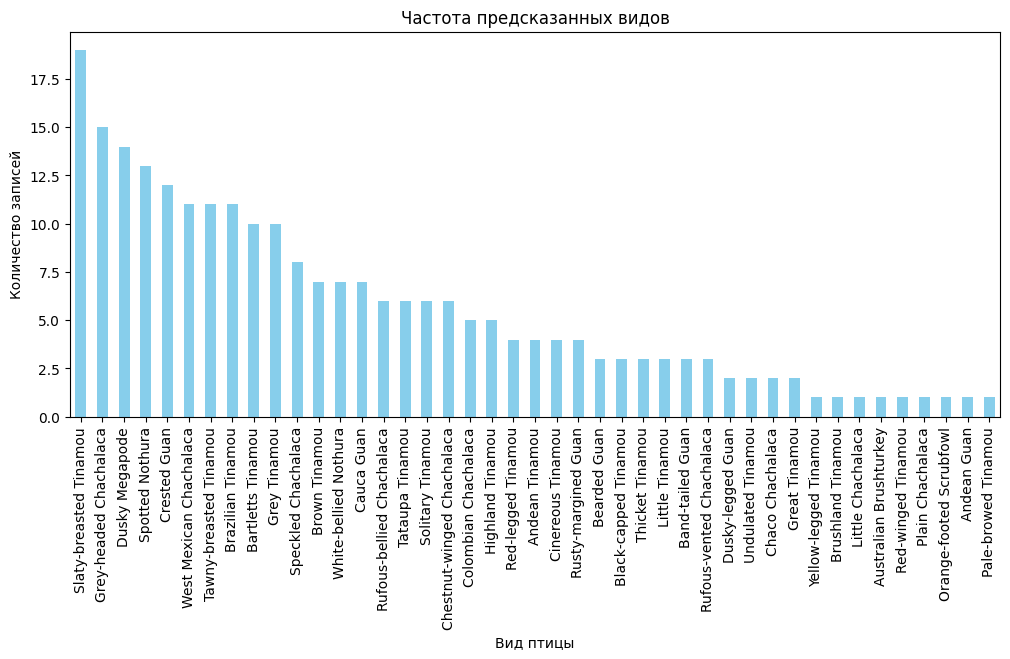

In [19]:
import matplotlib.pyplot as plt

# Считаем сколько раз модель предсказала каждый вид
counts = df['pred_label'].value_counts()

# Строим столбчатую диаграмму
counts.plot(kind='bar', color="skyblue", figsize=(12,5))
plt.title("Частота предсказанных видов")
plt.xlabel("Вид птицы")
plt.ylabel("Количество записей")
plt.show()

#8. Сравнение с ground truth (метаданные Xeno-Canto)

## Оценка качества модели

Сравниваем предсказания модели с реальными видами птиц. Настоящий вид (ground truth) извлекаем из названия файла — мы же сами его задавали при скачивании.

**Метрики:**
- **Top-1 accuracy** — как часто модель угадывает с первого раза
- **Top-3 accuracy** — как часто правильный ответ попадает в тройку лучших предсказаний

In [12]:
import re

# Функция для извлечения настоящего названия птицы из имени файла
# Например: "American_Robin_3.wav" -> "American Robin"
def extract_gt(filename):
    # убираем расширение
    name = filename.replace(".wav","")
    # убираем индекс (последний _цифра)
    name = re.sub(r"_\d+$", "", name)
    # заменяем _ на пробелы
    return name.replace("_", " ")

# Добавляем колонку с ground truth (настоящий вид птицы)
df["gt_common"] = df["file"].apply(extract_gt)

# Проверим первые примеры
print(df["gt_common"].head())

# Сравниваем предсказание с реальным видом (без учета регистра)
df["match_top1"] = (df["pred_label"].str.lower() == df["gt_common"].str.lower()).astype(int)

# Считаем точность - доля правильных предсказаний
top1_acc = df["match_top1"].mean()
print(f"Top-1 accuracy: {top1_acc:.3f}")

0    White-bellied Nothura
1          Tataupa Tinamou
2             Bearded Guan
3         Highland Tinamou
4          Spotted Nothura
Name: gt_common, dtype: object
Top-1 accuracy: 0.287


#Шаг 9. Top‑3 accuracy

In [13]:
# Проверяем, попал ли правильный ответ хотя бы в топ-3 предсказаний
def top3_match(row):
    gt = row["gt_common"].lower()
    # Проверяем есть ли правильный вид среди трех лучших предсказаний
    return int(any(p["label"].lower() == gt for p in row["top3"]))

# Применяем функцию к каждой строке
df["match_top3"] = df.apply(top3_match, axis=1)
top3_acc = df["match_top3"].mean()

print(f"Top-3 accuracy: {top3_acc:.3f}")

Top-3 accuracy: 0.421


# Шаг 10. Confusion Matrix

## Матрица ошибок

Confusion matrix показывает какие виды модель путает между собой. По диагонали — правильные предсказания, остальные ячейки — ошибки.

Это помогает понять слабые места модели и найти похожие по звучанию виды птиц.

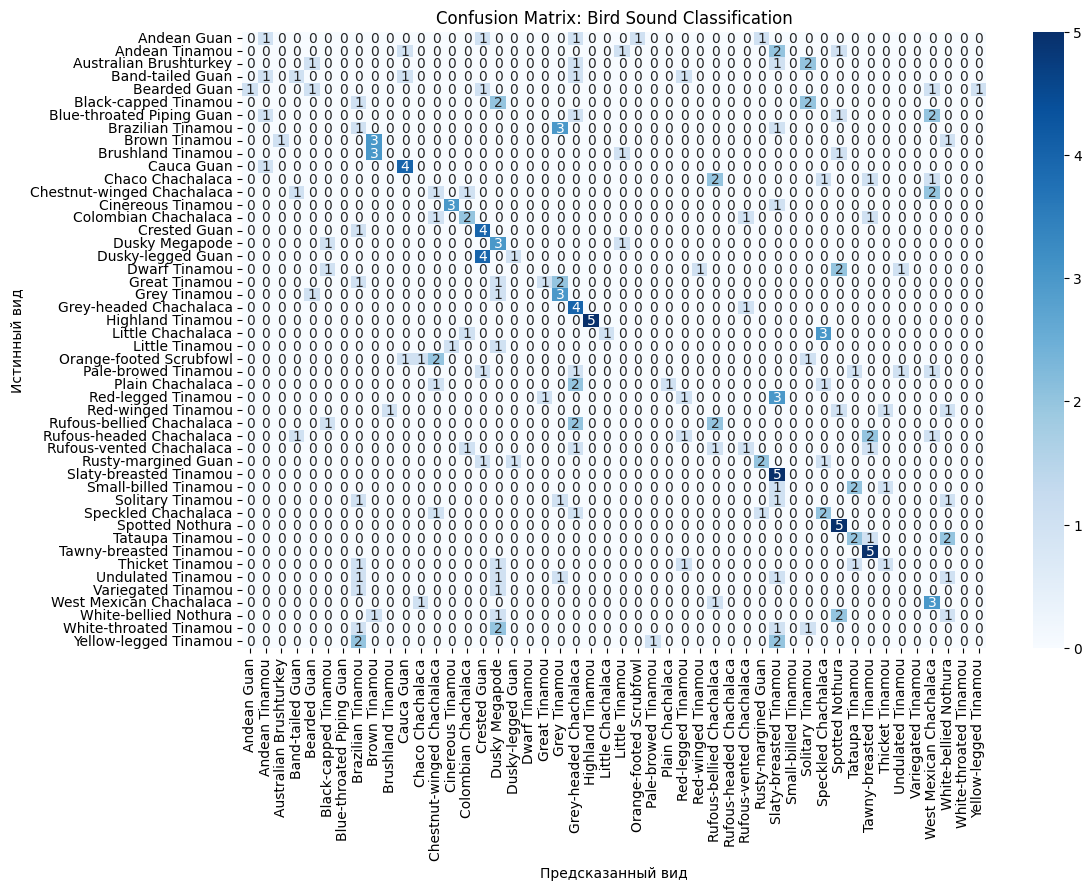

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Получаем список всех видов птиц из наших данных
labels = sorted(df["gt_common"].unique())

# Строим confusion matrix - показывает какие виды путает модель
# По диагонали - правильные предсказания, остальное - ошибки
cm = confusion_matrix(
    df["gt_common"].str.lower(),
    df["pred_label"].str.lower(),
    labels=[l.lower() for l in labels]
)

# Визуализируем матрицу как heatmap
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels,
            cmap="Blues")
plt.xlabel("Предсказанный вид")
plt.ylabel("Истинный вид")
plt.title("Confusion Matrix: Bird Sound Classification")
plt.show()

# Шаг 11. Precision, Recall, F1-score per species

## Детальные метрики по видам

Считаем precision, recall и f1-score для каждого вида отдельно.

- **Precision** — из всех предсказаний этого вида сколько оказались правильными
- **Recall** — из всех реальных записей этого вида сколько модель нашла
- **F1-score** — среднее между precision и recall, общая оценка качества

In [18]:
from sklearn.metrics import classification_report

# Получаем детальный отчет по метрикам для каждого вида
# precision - точность, recall - полнота, f1-score - среднее между ними
report = classification_report(
    df["gt_common"].str.lower(),
    df["pred_label"].str.lower(),
    output_dict=True,
    zero_division=0  # чтобы не было ошибок если вид ни разу не предсказан
)

# Преобразуем в таблицу для удобства
report_df = pd.DataFrame(report).transpose()

# Убираем служебные строки, оставляем только виды птиц
species_report = report_df.iloc[:-3][["precision", "recall", "f1-score"]]
# Сортируем по f1-score чтобы увидеть на каких видах модель работает лучше
species_report = species_report.sort_values("f1-score", ascending=False)

species_report.head(10)

,precision,recall,f1-score
highland tinamou,1.000000,1.0,1.000000
cauca guan,0.571429,0.8,0.666667
cinereous tinamou,0.750000,0.6,0.666667
tawny-breasted tinamou,0.454545,1.0,0.625000
spotted nothura,0.384615,1.0,0.555556
brown tinamou,0.428571,0.6,0.500000
crested guan,0.333333,0.8,0.470588
rusty-margined guan,0.500000,0.4,0.444444
slaty-breasted tinamou,0.263158,1.0,0.416667
grey tinamou,0.300000,0.6,0.400000


# Шаг 12. Визуализация метрик

## Визуализация метрик

График precision/recall/f1 для каждого вида. Сразу видно на каких птицах модель работает хорошо, а на каких плохо.

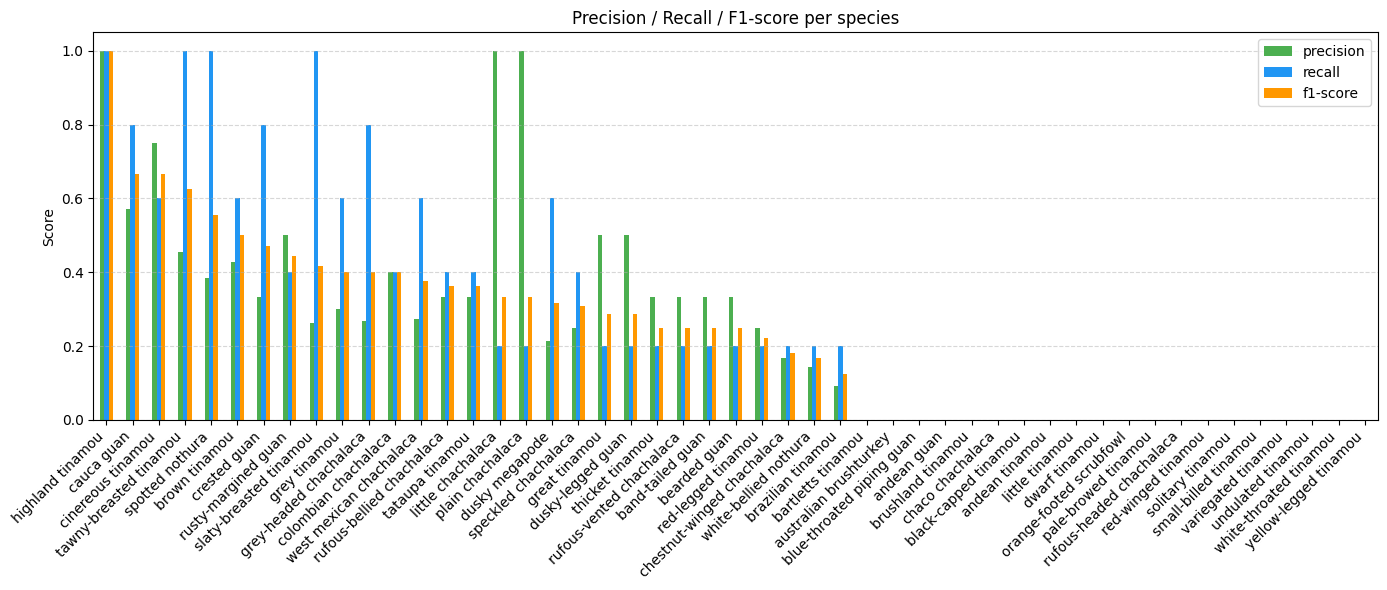

In [16]:
# Строим график метрик для каждого вида птиц
species_report.plot(kind="bar", figsize=(14,6), color=["#4caf50", "#2196f3", "#ff9800"])
plt.title("Precision / Recall / F1-score per species")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")  # поворачиваем подписи чтобы не налезали друг на друга
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()  # чтобы всё влезло
plt.show()

## Общие метрики

Итоговая оценка модели по всему датасету.

- **Macro avg** — среднее по всем видам, каждый вид весит одинаково
- **Weighted avg** — взвешенное среднее, учитывает сколько записей каждого вида
- **Accuracy** — общая доля правильных ответов

In [17]:
# Выводим общие метрики по всем видам
# Macro avg - среднее по всем классам (каждый вид весит одинаково)
# Weighted avg - взвешенное среднее (учитывает сколько примеров каждого вида)
print("Macro avg F1:", report["macro avg"]["f1-score"])
print("Weighted avg F1:", report["weighted avg"]["f1-score"])
print("Overall accuracy:", report["accuracy"])

Macro avg F1: 0.22867642964787083
Weighted avg F1: 0.2334405219322015
Overall accuracy: 0.2875


# Шаг 13. система мониторинга

## Система мониторинга и оповещений

Для автоматизации экологического мониторинга реализована система оповещений, которая анализирует результаты классификации и выявляет важные события.

**Типы оповещений:**
- **RARE_SPECIES** — обнаружен редкий или охраняемый вид птицы
- **LOW_CONFIDENCE** — модель не уверена в предсказании (score < 50%), возможно плохое качество записи
- **UNKNOWN_SOUND** — очень низкая уверенность (score < 30%), возможно неизвестный вид или посторонний шум
- **HIGH_FREQUENCY** — аномально высокая активность какого-то вида
- **LOW_FREQUENCY** — подозрительно низкая активность вида

Все оповещения сохраняются в папку `alerts/` в формате JSON для дальнейшего анализа.

In [20]:
import json
import os
from datetime import datetime

# Создаем папку для оповещений
os.makedirs("alerts", exist_ok=True)

# Настройки порогов
LOW_CONFIDENCE_THRESHOLD = 0.5   # ниже этого - модель не уверена
UNKNOWN_SOUND_THRESHOLD = 0.3    # ниже этого - возможно неизвестный звук

# Список редких видов (для примера, можно расширить)
RARE_SPECIES = [
    "spotted owl",
    "california condor",
    "whooping crane",
    "ivory-billed woodpecker"
]

# Собираем все оповещения
alerts = []

for idx, row in df.iterrows():
    file_name = row["file"]
    pred_label = row["pred_label"]
    pred_score = row["pred_score"]

    # Проверка 1: Обнаружен редкий вид
    if pred_label.lower() in [s.lower() for s in RARE_SPECIES]:
        alerts.append({
            "type": "RARE_SPECIES",
            "file": file_name,
            "species": pred_label,
            "confidence": round(pred_score, 3),
            "message": f"Обнаружен редкий вид: {pred_label}"
        })

    # Проверка 2: Низкая уверенность модели
    if pred_score < LOW_CONFIDENCE_THRESHOLD:
        alerts.append({
            "type": "LOW_CONFIDENCE",
            "file": file_name,
            "species": pred_label,
            "confidence": round(pred_score, 3),
            "message": f"Низкая уверенность модели ({pred_score:.1%})"
        })

    # Проверка 3: Возможно неизвестный звук
    if pred_score < UNKNOWN_SOUND_THRESHOLD:
        alerts.append({
            "type": "UNKNOWN_SOUND",
            "file": file_name,
            "species": pred_label,
            "confidence": round(pred_score, 3),
            "message": f"Возможно неизвестный вид или шум"
        })

# Проверка 4: Аномальная частота видов
# Считаем среднее количество записей на вид
species_counts = df["pred_label"].value_counts()
mean_count = species_counts.mean()
std_count = species_counts.std()

for species, count in species_counts.items():
    # Если вид встречается слишком часто (больше 2 стандартных отклонений)
    if count > mean_count + 2 * std_count:
        alerts.append({
            "type": "HIGH_FREQUENCY",
            "species": species,
            "count": int(count),
            "message": f"Аномально высокая активность вида {species}: {count} записей"
        })
    # Или слишком редко
    elif count < mean_count - 1.5 * std_count and count <= 1:
        alerts.append({
            "type": "LOW_FREQUENCY",
            "species": species,
            "count": int(count),
            "message": f"Очень низкая активность вида {species}: {count} записей"
        })

# Сохраняем оповещения в JSON файл
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
alert_file = f"alerts/alerts_{timestamp}.json"

alert_report = {
    "generated_at": datetime.now().isoformat(),
    "total_files_processed": len(df),
    "total_alerts": len(alerts),
    "alerts": alerts
}

with open(alert_file, "w", encoding="utf-8") as f:
    json.dump(alert_report, f, ensure_ascii=False, indent=2)

# Выводим сводку
print(f"Обработано файлов: {len(df)}")
print(f"Всего оповещений: {len(alerts)}")
print(f"Отчет сохранен в: {alert_file}")
print()

# Показываем по типам
from collections import Counter
alert_types = Counter(a["type"] for a in alerts)
for alert_type, count in alert_types.items():
    print(f"  {alert_type}: {count}")

Обработано файлов: 240
Всего оповещений: 260
Отчет сохранен в: alerts/alerts_20251202_185002.json

  LOW_CONFIDENCE: 156
  UNKNOWN_SOUND: 102
  HIGH_FREQUENCY: 2


Редкий вид — заведем список редких птиц, если модель их нашла — алерт
Низкая уверенность — если score < 0.5, значит модель не уверена
Неизвестный звук — если даже топ-1 ниже 0.3, что-то странное
Статистика аномалий — если какой-то вид встречается слишком часто или редко относительно других

In [25]:
!ls -la /content

total 116
drwxr-xr-x 1 root root  4096 Dec  2 19:09 .
drwxr-xr-x 1 root root  4096 Dec  2 17:58 ..
drwxr-xr-x 2 root root  4096 Dec  2 18:50 alerts
-rw-r--r-- 1 root root 60891 Dec  2 18:23 bird_classification_results.csv
drwxr-xr-x 2 root root 16384 Dec  2 18:13 bird_sounds
drwxr-xr-x 2 root root 16384 Dec  2 18:17 bird_wav
drwxr-xr-x 3 root root  4096 Dec  2 19:09 ecosystem-monitoring
-rw-r--r-- 1 root root  3387 Dec  2 19:01 README.md
